In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

## K-MEANS

### Generating clusters to show how K-Means reproduce them 

#### Generating centers

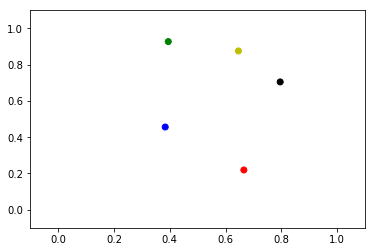

In [9]:
trueK = 5 # Desired number of clusters
colors = 'bgrykcm'
dim = 2 # dimension of feature space
n = 40 # points per cluster
trueCentroids = np.random.rand(trueK,dim) # generating centroids at random

if dim==2:
    plt.scatter(trueCentroids[:,0],trueCentroids[:,1], color=colors)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

#### Generating points around each center
#### Using multivariate normal distribution with a randomly generated covariance matrix

In [12]:
sigma_xx = 0.002 # factor for variance
sigma_xy = 0.0002 # factor for covariance
XasList = [] # storing the points around each center, as a list of arrays (one array per center)
X = trueCentroids # The actual centroids, to which the generated points will be added

# loop through the centroids
for c in trueCentroids:
    # data generated for each centroid:
    X_c = np.random.multivariate_normal(c,np.array([[sigma_xx*np.random.rand(),  sigma_xy*(2*np.random.rand()-1)], 
                                                    [sigma_xy*(2*np.random.rand()-1), sigma_xx*np.random.rand()]]), n) 
    XasList.append(X_c) # list of arrays
    X = np.append(X,X_c, axis=0) # single array

np.random.shuffle(X) # shuffle the array

#### Computing clusters

In [13]:
kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)         

#### Visualizing true vs computed clusters

Note that the colors do not match because the labels chosen by the clustering algorithm do not need to match the artificial ones we started with.

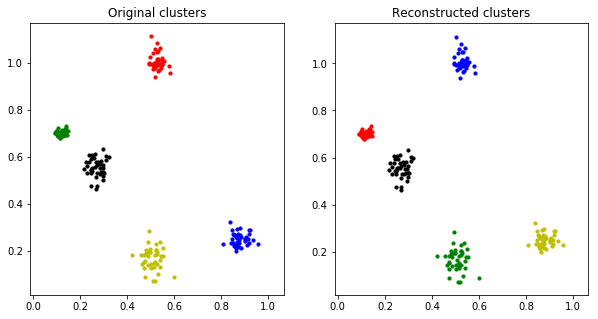

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for J in range(trueK):
    X_c = XasList[J]
    plt.scatter(X_c[:, 0], X_c[:, 1], c=colors[J], s=10) 
    plt.title("Original clusters")
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.axis('equal')
    
plt.subplot(1,2,2)    
for J in range(trueK):
    X_J = X[kmeans.labels_==J]
    plt.title("Reconstructed clusters")
    plt.scatter(X_J[:, 0], X_J[:, 1], c=colors[J], s=10)
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.axis('equal')
plt.show()    

### Measuring Clustering Performance

#### A function that measures the _cost_ of a specific clustering is called _inertia_

#### Inertia is computed as the sum of the square distances between each point and the center of the cluster to which the point is assigned.

Inertia is one of the attributes of the learned model (below is redefined as getInertia, although not used)

A complementary measure of performance is to look at what below is called inertia2, which is the sum of the squares distances between each point and the 2nd closest cluster

A nice clustering solution should have small inertia, and large inertia2: that means:

    - points are close to the center of their cluster
    - points are far from the center of the other clusters (since they are far to the closest center of the other clusters)

In [15]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [16]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

In addition to _inertia_ we compute the ration between _interia_ and _inertia2_. 

Another performance measure is called _silhouette_:

The silhouette $s(x)$ for a point $x$ is defined as:

$$ s(x) = \frac{b(x)-a(x)}{\max\{a(x),b(x)\}} $$

where 

- $a(x)$ is the average distance between $x$ and the points in the cluster $x$ belongs

- $b(x)$ is the lowest average distance between $x$ and the points the clusters $x$ does not belong to

$s(x)$ is a quantity in $[-1,1]$. The silhouette score is the average silhouette score among all the points: $\frac{1}{|X|} \sum_x s(x)$

### Computing 3 performance measures for a range of values of $k$

In [17]:
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

### Plotting performances

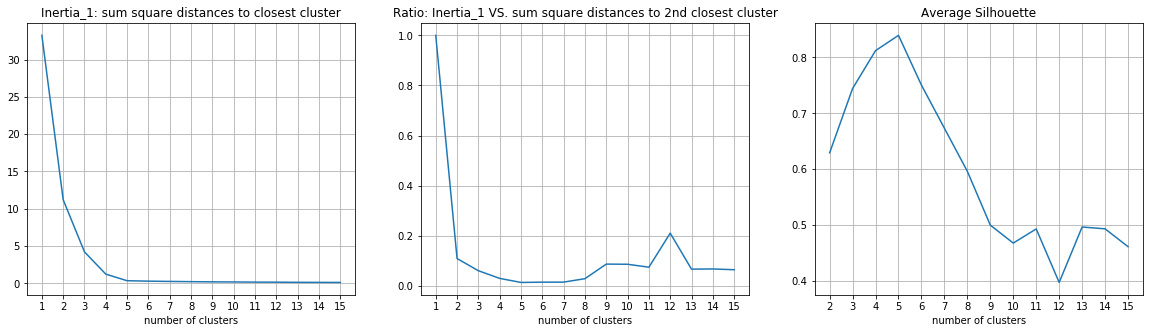

In [18]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

### Analyzing the plots to determine the optimal value of $k$

In this case the data was created to have $k$ clusters, but in practice this is of course unknown, and one of the user's tasks is to determine the appropriate value of $k$.

In the first case (looking at inertias) what we are looking for is an "elbow" in the graph. In this case, it is located around $k=5$. Notice that we do not choose the value of $k$ with the smallest value since the inertia keeps decreasing as $k$ increase. This is by construction of the quantity _inertia_. 

When looking at the ration between inertia_1 and inertia_2, one looks for a minimum value, which in this case corresponds with $k=5$ as well.

The silhouette gives higher values for best clusterings, so what we look for is a maximum, which happens again at $k=5$.

With real data (non-synthetic) it is trickier to find the best value of $k$ since it is not so obvious as in the example above. Often there are a few options that seem reasonable. Having these 3 differents approaches to determine a convenient value of $k$ should help narrowing down the options for $k$.

## Hierarchical Clustering

For $k$ between 10 and 2 we can observe how the hierarchical clustering works, for the different _linkage_ methods.

The _linkage_ is the criteria by which it is determined which 2 clusters are joined:

- ward: the clusters joined are those that result in minimal variance

- average: the clusters joined are those with minimal average distance between every pair of points (one in each cluster)

- complete: the clusters joined minimize the maximum distance between a pair of points, one in each cluster

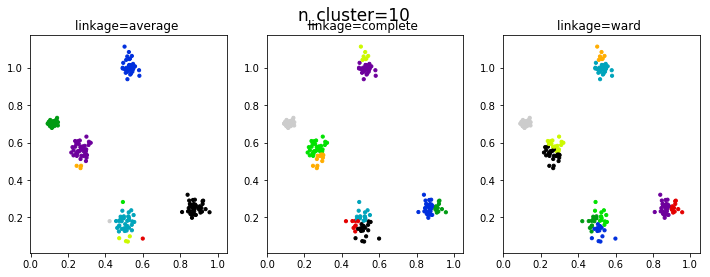

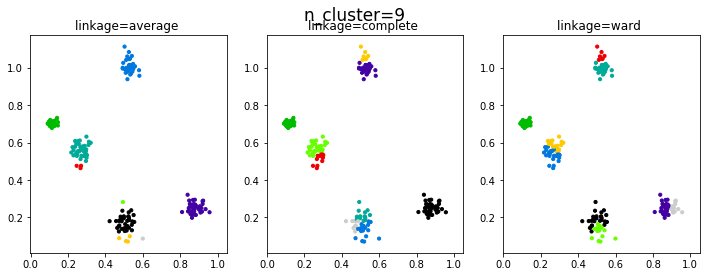

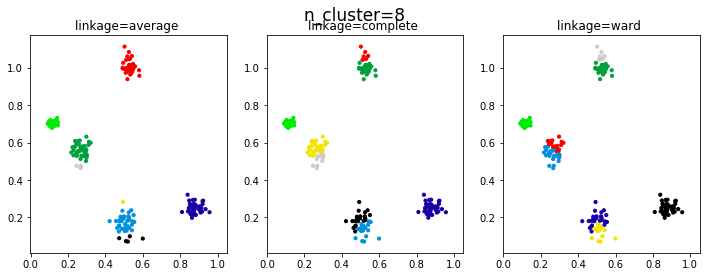

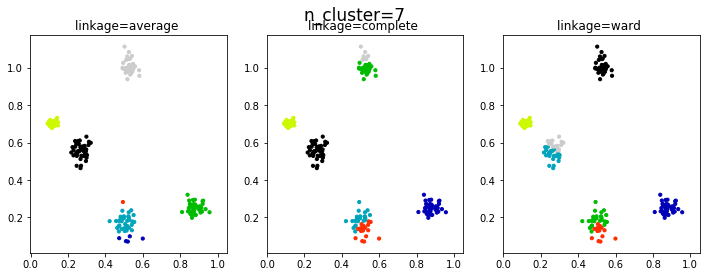

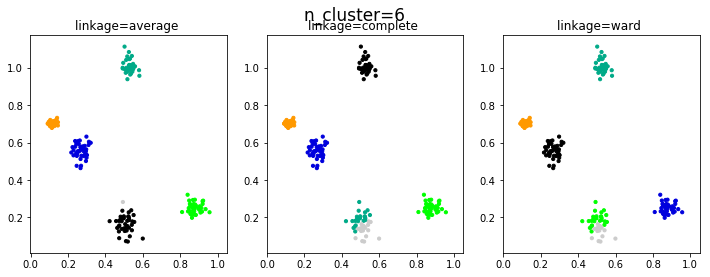

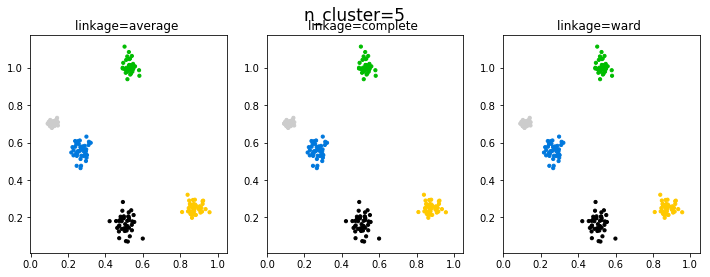

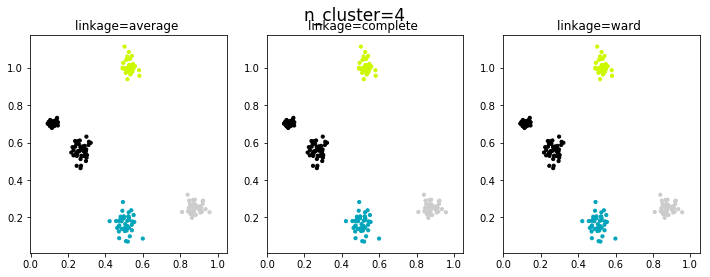

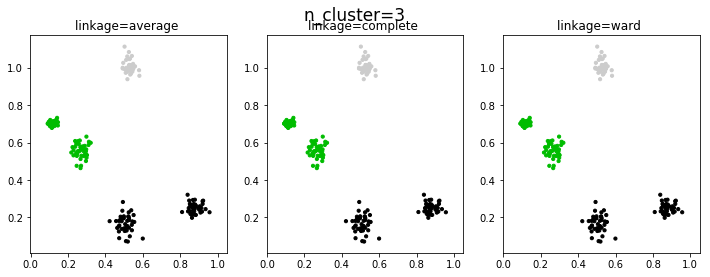

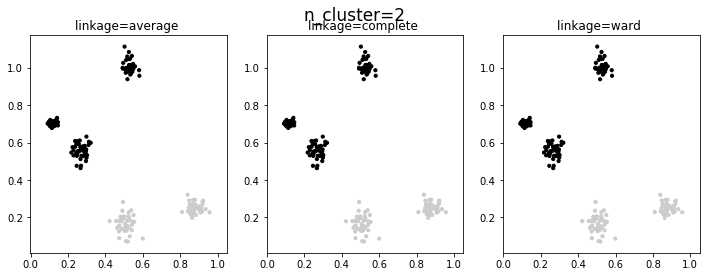

In [19]:
for k in reversed(np.arange(2,11)) :
    
    plt.figure(figsize=(12,4))
    for index, linkage in enumerate(('average', 'complete', 'ward')):
        
        plt.subplot(1, 3, index + 1)
        model = AgglomerativeClustering(linkage=linkage, n_clusters=k)
        model.fit(X)
        plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.spectral, s=10)
        plt.title('linkage=%s ' % (linkage))
        plt.xlim(-0.2,1.2)
        plt.ylim(-0.2,1.2)
        plt.axis('equal')
        plt.suptitle('n_cluster=%i' % k, size=17)
        
    plt.show()

Although the different linkage methods give different clusters (even for the same value of $k$), the clusterings are very similar for values around $k=5$

#### Dendrogram

The hierarchical clustering implementation in scipy provides a dendrogram to visualize the way clusters are joined

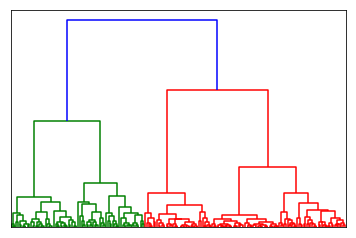

In [45]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z)
plt.xticks(())
plt.yticks(())
plt.show()

## DBSCAN clustering

We generate a new data set for this example

In [47]:
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


n = 1000
noisy_circles = datasets.make_circles(n_samples=n, factor=.5, noise=.07)
noisy_moons = datasets.make_moons(n_samples=n, noise=.1)
blobs = datasets.make_blobs(n_samples=n, random_state=8)

In [48]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
clustering_names = ['KMeans', 'DBSCAN']

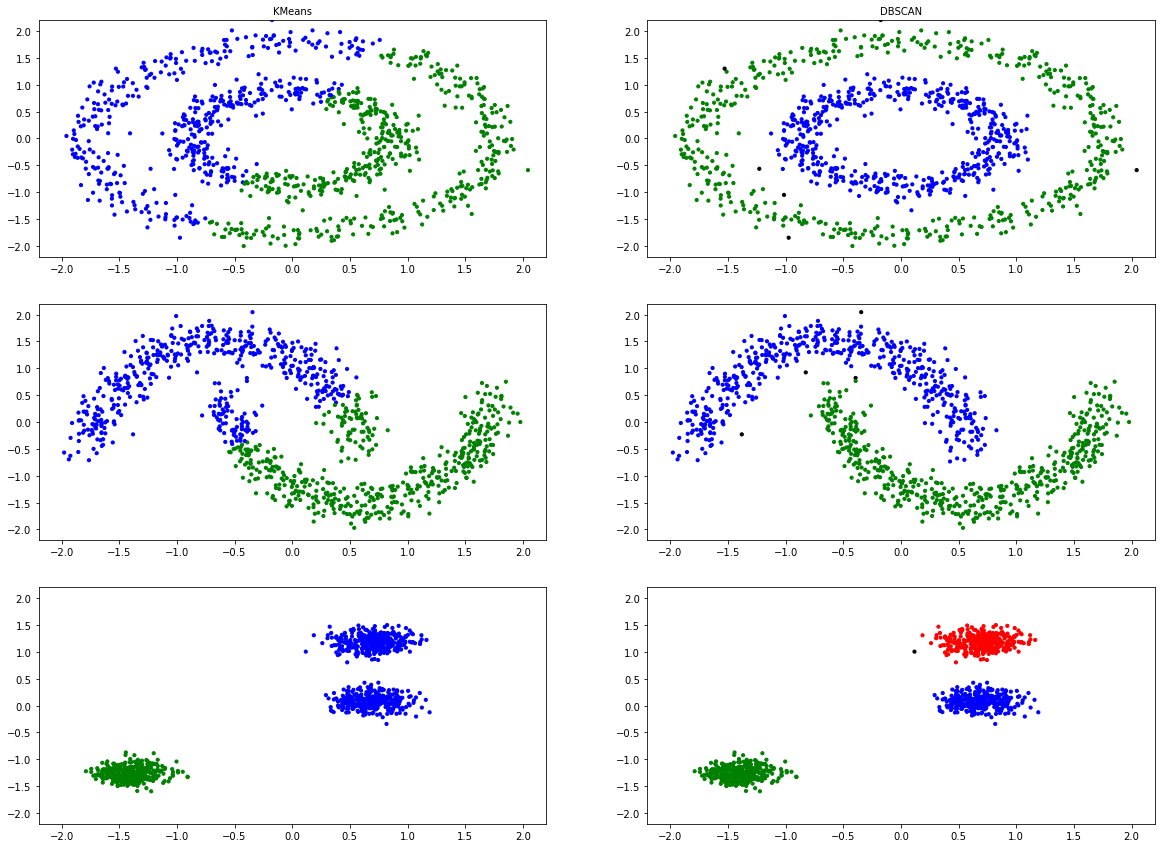

In [52]:
plt.figure(figsize=(20, 20))

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    # normalize dataset
    X = StandardScaler().fit_transform(X)

    # create clustering estimators
    kmeans = cluster.KMeans(n_clusters=2)
    dbscan = cluster.DBSCAN(eps=.2, min_samples=5)

    clustering_algorithms = [kmeans, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        y_pred = algorithm.labels_.astype(np.int)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=10)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        plt.xlim(-2.2, 2.2)
        plt.ylim(-2.2, 2.2)
        plot_num += 1

plt.show()

Based on the first 2 (top) shapes, DBSCAN does a better job at identifying the true underlying patterns.

Regarding the 3rd shape, it is open to discussion whether 2 or 3 clusters is more appropriate.

Outliers are depicted as black on the right scatterplots (DBSCAN)